In [3]:
import gym
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random

In [4]:
class Fourier_Basis:
  def __init__(self, order, k):
    #self.env = env
    self.order = [order]*k
    self.coefficients = np.array([])

  def get_coefficients(self):
    prods = [range(0, i+1) for i in self.order]
    #print(prods)
    coeffs = [v for v in itertools.product(*prods)]
    self.coefficients = np.array(coeffs)
    return self.coefficients
  
  def value(self, state):
    self.get_coefficients()
    return np.cos(np.pi*np.dot(self.coefficients, state))
  

class Expected_SARSA:
  def __init__(self, env, gamma, order, k):
    self.state_num = env.observation_space.shape[0]
    self.action_num = env.action_space.n
    self.w = np.random.uniform(-0.001, 0.001, ((order + 1)**k, self.action_num))
    self.gamma = gamma

  #define the greedy policy
  def policy(self, states, epsilon):
    if random.uniform(0, 1) < epsilon:
        return np.random.randint(self.action_num)
    else:
        return states.argmax()

  def apply_weight(self, state): #dot product for linear approximation function with weights vector
    return np.dot(state, self.w)

  def update(self, current, target, reward, state, action, alpha, done):
    error = reward + self.gamma * target* (not done) - current
    #print(error)
    self.w[:, action] += alpha * error * state

def Expected_SARSA_Acrobat(env, alpha, epsilon, order, k, gamma = 0.99):
  trial_reward = []
  for j in range(trials):
    Expected_SAR = Expected_SARSA(env, gamma, order, k)
    FB = Fourier_Basis(order, k)
    u_state = env.observation_space.high
    l_state = env.observation_space.low
    d_state = u_state - l_state
    #print(d_state)


    rewards = []
    for i in range(episodes):
      s = env.reset()
      reward_ep = 0
      done = False
      state_encoding = (env.reset() - l_state) / d_state
      #print(state_encoding)
      state_cos = FB.value(state_encoding)
      state_value = Expected_SAR.apply_weight(state_cos)
      while not done:
        a = Expected_SAR.policy(state_value, epsilon)
        v_i = state_value[a]
        s, reward, done, _ = env.step(a)
        next_state = (s - l_state) / d_state
        next_state_cos = FB.value(next_state)
        v_next = epsilon * np.mean(Expected_SAR.apply_weight(next_state_cos)) + (1 - epsilon) * np.max(Expected_SAR.apply_weight(next_state_cos))
        Expected_SAR.update(v_i, v_next, reward, state_cos, a, alpha, done)
        state_encoding = next_state
        state_cos = FB.value(state_encoding)
        state_value = Expected_SAR.apply_weight(state_cos)
        reward_ep += reward
      rewards.append(reward_ep)
    trial_reward.append(rewards)

  return trial_reward

In [14]:
env = gym.make("MountainCar-v0")
obs = env.reset()

#define the parameters
epsilon = [0.1, 0.01, 0.001]
order = 10
k = env.observation_space.shape[0]
alpha = [ 5e-4, 1e-3, 5e-3]
trials = 50
gamma = 0.99
episodes = 1000

[2024-04-02 23:32:46,571] Making new env: MountainCar-v0
C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\gym\envs\registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [15]:
MC_epsilon_return_SARSA = []
for j in range(len(alpha)):
  learning_return_SARSA = []
  for i in range(len(epsilon)):
    avg_return = Expected_SARSA_Acrobat(env, alpha[j], epsilon[i], order, k, gamma)
    learning_return_SARSA.append(avg_return)
  MC_epsilon_return_SARSA.append(learning_return_SARSA)

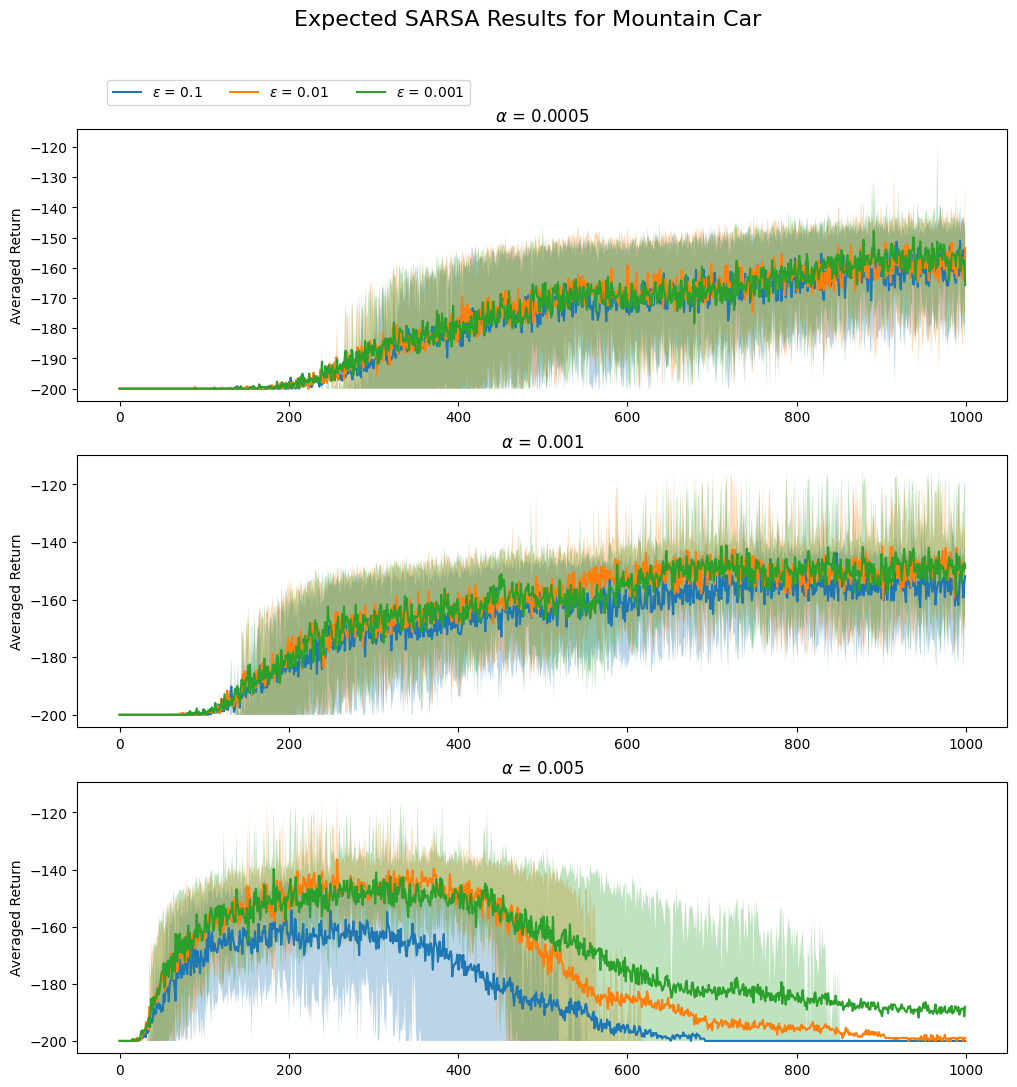

In [19]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

#print(learning_return[0])

plt.rcParams["figure.figsize"]=10,5

for i, learning in enumerate(MC_epsilon_return_SARSA):

  for j, alpha_data in enumerate(learning):
    ar_1_mean = np.mean(alpha_data, axis = 0)
    par_1_75, par_1_25 = np.percentile(alpha_data, [75, 25], axis = 0)
    if i == 0:
      axs[i].plot(range(episodes), ar_1_mean, label = f'${{\\epsilon}}$ = {epsilon[j]}')
    else:
      axs[i].plot(range(episodes), ar_1_mean)
    axs[i].set_title(f'${{\\alpha}}$ = {alpha[i]}')
    axs[i].fill_between(range(episodes), par_1_25, par_1_75, alpha=0.3)

plt.setp(axs, ylabel = 'Averaged Return')
fig.suptitle('Expected SARSA Results for Mountain Car', fontsize = 16)

fig.legend(bbox_to_anchor=(0.15, 0.9, 1., .102), loc='lower left',
                      ncol=3, borderaxespad=0.)

In [20]:
import os
import pickle

In [21]:
pkl_path = './Expected_SARSA/MC/'
os.makedirs(pkl_path, exist_ok=True)

dataStore = {}
for i, learning in enumerate(MC_epsilon_return_SARSA):
    dataStore[alpha[i]] = {}
    for j, alpha_data in enumerate(learning):
        dataStore[alpha[i]][epsilon[j]] = alpha_data
    
with open(pkl_path + 'Results_ES_MC_' + '.pkl', 'wb') as fp:
        pickle.dump(dataStore, fp)
        print('dictionary saved successfully to file')

dictionary saved successfully to file


In [9]:
class discretize_action:
    def __init__(self, env) -> None:
        self.env = env
        self.action_space = self.env.action_space

    def discretize_action_space(self, steps_per_dimension):
        """
        Discretizes the action space.

        Parameters:
        - low: The lower bound of the action space.
        - high: The higher bound of the action space.
        - steps_per_dimension: Number of discrete steps per dimension.

        Returns:
        - A list of discretized actions.
        """
        low = self.action_space.low
        high = self.action_space.high

        # Generate a range of values for each dimension
        ranges = [np.linspace(low[i], high[i], steps_per_dimension) for i in range(len(low))]
        
        # Create a meshgrid of all possible combinations
        mesh = np.meshgrid(*ranges)
        
        # Reshape the meshgrid to create a list of actions
        self.actions = np.vstack([m.flatten() for m in mesh]).T
        
        return self.actions
    
    def allocate_action(self, action):
        distances = np.linalg.norm(self.actions - action, axis=1)
        nearest_index = np.argmin(distances)
        return self.actions[nearest_index]


class Expected_SARSA_Continuous_Action:
  def __init__(self, env, gamma, order, k):
    self.state_num = env.observation_space.shape[0]
    discrete_actions = discretize_action(env)
    action_list = discrete_actions.discretize_action_space(steps_per_dimension)
    self.action_num = len(action_list)
    self.w = np.random.uniform(-0.001, 0.001, ((order + 1)**k, self.action_num))
    self.gamma = gamma

  #define the greedy policy
  def policy(self, states, epsilon):
    if random.uniform(0, 1) < epsilon:
        return np.random.randint(self.action_num)
    else:
        return states.argmax()

  def apply_weight(self, state): #dot product for linear approximation function with weights vector
    return np.dot(state, self.w)

  def update(self, current, target, reward, state, action, alpha, done):
    error = reward + self.gamma * target* (not done) - current
    #print(error)
    self.w[:, action] += alpha * error * state


def Expected_SARSA_Continuous(env, alpha, epsilon, order, k, gamma = 0.99):
  trial_reward = []
  for j in range(trials):
    Expected_SAR = Expected_SARSA_Continuous_Action(env, gamma, order, k)
    FB = Fourier_Basis(order, k)
    u_state = env.observation_space.high
    l_state = env.observation_space.low
    d_state = u_state - l_state
    print(d_state)


    rewards = []
    for i in range(episodes):
      s, _ = env.reset()
      reward_ep = 0
      done = False
      state_encoding = (s - l_state) / d_state
      #print(state_encoding)
      state_cos = FB.value(state_encoding)
      state_value = Expected_SAR.apply_weight(state_cos)
      while not done:
        a = Expected_SAR.policy(state_value, epsilon)
        v_i = state_value[a]
        #print(action_list[a])
        s, reward, done,  _ = env.step(action_list[a])
        next_state = (s - l_state) / d_state
        next_state_cos = FB.value(next_state)
        v_next = epsilon * np.mean(Expected_SAR.apply_weight(next_state_cos)) + (1 - epsilon) * np.max(Expected_SAR.apply_weight(next_state_cos))
        Expected_SAR.update(v_i, v_next, reward, state_cos, a, alpha, done)
        state_encoding = next_state
        state_cos = FB.value(state_encoding)
        state_value = Expected_SAR.apply_weight(state_cos)
        reward_ep += reward
      rewards.append(reward_ep)
    trial_reward.append(rewards)

  return trial_reward

In [19]:
env = gym.make("MountainCarContinuous-v0")
obs = env.reset()

#define the parameters
epsilon = [0.1, 0.01, 0.001]
order = 10
k = env.observation_space.shape[0]
alpha = [0.01, 0.05, 0.1] #, 5e-4, 1e-4]
steps_per_dimension = 7
discrete_actions = discretize_action(env)
action_list = discrete_actions.discretize_action_space(steps_per_dimension)
trials = 3
gamma = 0.99
episodes = 200


In [20]:
MCC_epsilon_return_SARSA = []
for j in range(len(alpha)):
  learning_return_SARSA = []
  for i in range(len(epsilon)):
    avg_return = Expected_SARSA_Continuous(env, alpha[j], epsilon[i], order, k, gamma)
    learning_return_SARSA.append(avg_return)
  MCC_epsilon_return_SARSA.append(learning_return_SARSA)

[1.8000001 0.14     ]


C:\Users\chery\AppData\Local\Temp\ipykernel_39256\2402575458.py:58: RuntimeWarning: invalid value encountered in scalar subtract
  error = reward + self.gamma * target* (not done) - current


[1.8000001 0.14     ]
[1.8000001 0.14     ]


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


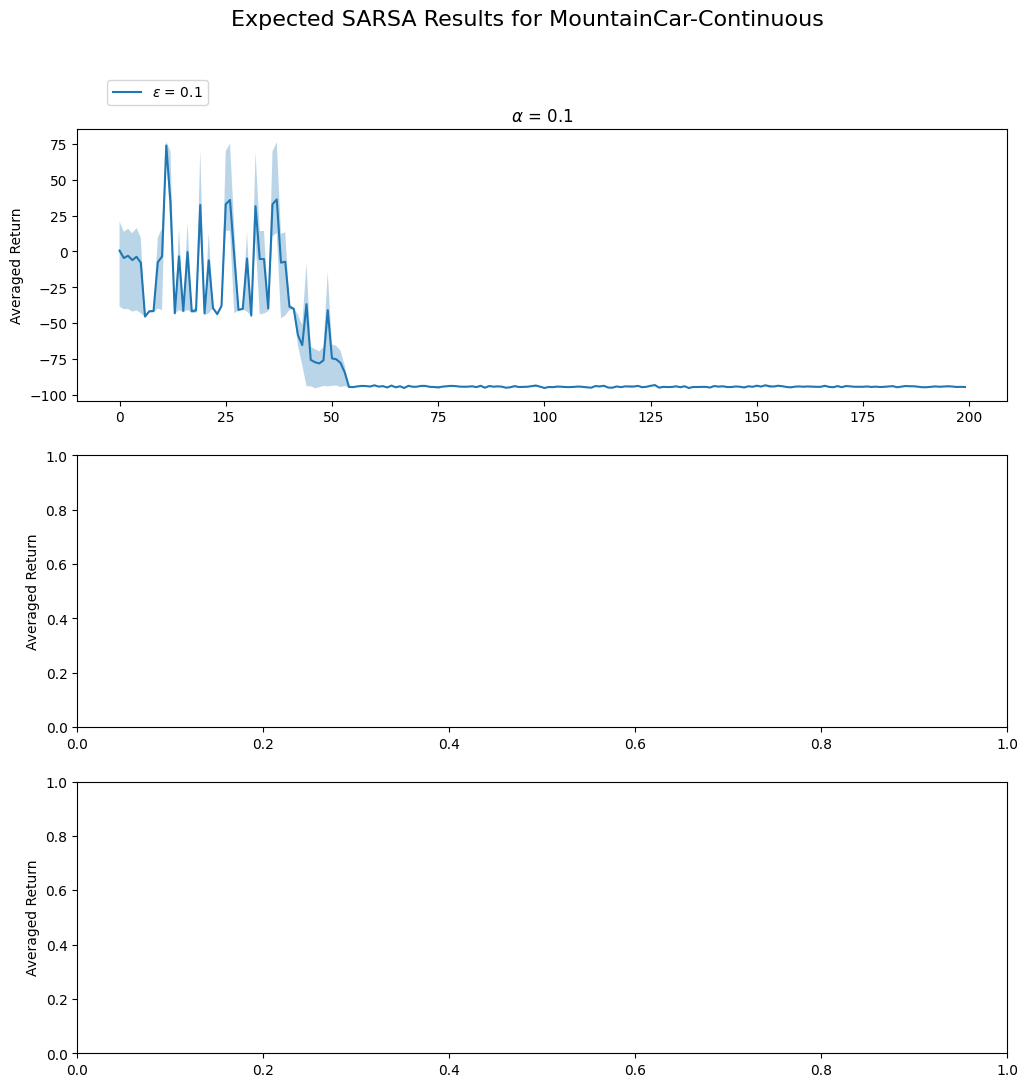

In [21]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

#print(learning_return[0])

plt.rcParams["figure.figsize"]=10,5

for i, learning in enumerate(MCC_epsilon_return_SARSA):

  for j, alpha_data in enumerate(learning):
    ar_1_mean = np.mean(alpha_data, axis = 0)
    par_1_75, par_1_25 = np.percentile(alpha_data, [75, 25], axis = 0)
    if i == 0:
      axs[i].plot(range(episodes), ar_1_mean, label = f'${{\\epsilon}}$ = {epsilon[j]}')
    else:
      axs[i].plot(range(episodes), ar_1_mean)
    axs[i].set_title(f'${{\\alpha}}$ = {alpha[i]}')
    axs[i].fill_between(range(episodes), par_1_25, par_1_75, alpha=0.3)

plt.setp(axs, ylabel = 'Averaged Return')
fig.suptitle('Expected SARSA Results for MountainCar-Continuous', fontsize = 16)

fig.legend(bbox_to_anchor=(0.15, 0.9, 1., .102), loc='lower left',
                      ncol=3, borderaxespad=0.)